In [1]:
# CIS 3D color router verification
# Find OE


# ## 1. Simulation Environment

import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
from matplotlib import pyplot as plt
import os

mp.verbosity(1)

design_dir = "./CIS_result/"

# 디렉터리가 없으면 생성
if not os.path.exists(design_dir):
    os.makedirs(design_dir)

# scaling & refractive index
um_scale = 2

Air = mp.Medium(index=1.0)
SiN = mp.Medium(epsilon=4)
SiO2 = mp.Medium(epsilon=2.1)
TiO2 = mp.Medium(epsilon=7)
SiPD = mp.Medium(epsilon=11.8)

# 설계 공간
design_region_width_x = 2.8 # 디자인 영역 x
design_region_width_y = 2.8 # 디자인 영역 y
design_region_height = 2 # 디자인 영역 높이 z

# 해상도 및 사이즈 설정
resolution = 25 
gapop = 1 ####################################################################################################
air_gap = 0
dti = 0.4
subpixelsize = design_region_width_x/2 - dti
if gapop == 1:
    air_gap = dti/2
PDsize = 2
Lpml = 1 # PML 영역 크기
pml_layers = [mp.PML(thickness = Lpml, direction = mp.Z)]
Sourcespace = 1

# 전체 공간
Sx = design_region_width_x
Sy = design_region_width_y
Sz = PDsize + design_region_height + Sourcespace + Lpml
cell_size = mp.Vector3(Sx, Sy, Sz)

# structure load
structure_weight = np.loadtxt('lastdesign.txt')
# structure_weight = np.where(structure_weight < 0.5, 0.0, 1.0)
# np.savetxt('check.txt',structure_weight)


# 파장, 주파수 설정
wavelengths = np.linspace(0.40*um_scale, 0.70*um_scale, 31) 
frequencies = 1/wavelengths
nf = len(frequencies) # number of frequencies

# constraint 설정
minimum_length = 0.025  # minimum length scale (microns)
eta_i = 0.5  # blueprint (or intermediate) design field thresholding point (between 0 and 1)
eta_e = 0.55  # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e  # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)
design_region_resolution = int(resolution)

# source 설정
width = 0.4

fcen_red = 1/(0.65*um_scale)
fwidth_red = fcen_red * width

fcen_green = 1/(0.55*um_scale)
fwidth_green = fcen_green * width

fcen_blue = 1/(0.45*um_scale)
fwidth_blue = fcen_blue * width

src_0 = mp.GaussianSource(frequency=fcen_red, fwidth=fwidth_red, is_integrated=True)

src_1 = mp.GaussianSource(frequency=fcen_green, fwidth=fwidth_green, is_integrated=True)

src_2 = mp.GaussianSource(frequency=fcen_blue, fwidth=fwidth_blue, is_integrated=True)

source_center = [0, 0, Sz / 2 - Lpml - Sourcespace / 2 ] # Source 위치
source_size = mp.Vector3(Sx, Sy, 0)

source = [mp.Source(src_0, component=mp.Ex, size=source_size, center=source_center,),mp.Source(src_0, component=mp.Ey, size=source_size, center=source_center,),
            mp.Source(src_1, component=mp.Ex, size=source_size, center=source_center,),mp.Source(src_1, component=mp.Ey, size=source_size, center=source_center,),
            mp.Source(src_2, component=mp.Ex, size=source_size, center=source_center,),mp.Source(src_2, component=mp.Ey, size=source_size, center=source_center,)]

# 설계 영역의 픽셀 - 해상도와 디자인 영역에 따라 결정
Nx = int(round(design_region_resolution * design_region_width_x)) + 1
Ny = int(round(design_region_resolution * design_region_width_y)) + 1
Nz = int(round(design_region_resolution * design_region_height)) + 1

# 설계 영역과 물질을 바탕으로 설계 영역 설정
design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny, Nz), SiO2, TiO2, grid_type="U_MEAN")

design_variables.update_weights(structure_weight)

design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(0, 0, Sz / 2 - Lpml - Sourcespace - design_region_height/2),
        size=mp.Vector3(design_region_width_x-air_gap*2, design_region_width_y-air_gap*2, design_region_height),
    ),
)

# design region과 동일한 size의 Block 생성
geometry = [
    mp.Block(
        center=design_region.center, size=design_region.size, material=design_variables
    ),

    mp.Block(
        center=mp.Vector3(0, 0, -Sz/2 + PDsize/2), size=mp.Vector3(Sx, Sy, PDsize), material=SiO2
    ),

    # DTI가 있을 경우 사용
    mp.Block(
        center=mp.Vector3(Sx/4, Sy/4, -Sz/2 + PDsize/2), size=mp.Vector3(subpixelsize, subpixelsize,  PDsize), material=SiPD
    ),
    mp.Block(
        center=mp.Vector3(-Sx/4, -Sy/4, -Sz/2 + PDsize/2), size=mp.Vector3(subpixelsize, subpixelsize,  PDsize), material=SiPD
    ),
    mp.Block(
        center=mp.Vector3(Sx/4, -Sy/4, -Sz/2 + PDsize/2), size=mp.Vector3(subpixelsize, subpixelsize,  PDsize), material=SiPD
    ),
    mp.Block(
        center=mp.Vector3(-Sx/4, Sy/4, -Sz/2 + PDsize/2), size=mp.Vector3(subpixelsize, subpixelsize,  PDsize), material=SiPD
    )
]

sim = mp.Simulation(
    cell_size=cell_size, 
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air, # 빈공간
    resolution=resolution,
    k_point = mp.Vector3(0,0,0)
)

In [2]:
###############################################################################################################################
# ## 2. Optimization Environment

# 모니터 위치와 크기 설정 (focal point)
monitor_position_0, monitor_size_0 = mp.Vector3(-design_region_width_x/4, design_region_width_y/4, -Sz/2 + PDsize - 0.5/resolution), mp.Vector3(0.01,0.01,0) 
monitor_position_1, monitor_size_1 = mp.Vector3(-design_region_width_x/4, -design_region_width_y/4, -Sz/2 + PDsize - 0.5/resolution), mp.Vector3(0.01,0.01,0) 
monitor_position_2, monitor_size_2 = mp.Vector3(design_region_width_x/4, -design_region_width_y/4, -Sz/2 + PDsize - 0.5/resolution), mp.Vector3(0.01,0.01,0) 
monitor_position_3, monitor_size_3 = mp.Vector3(design_region_width_x/4, design_region_width_y/4, -Sz/2 + PDsize - 0.5/resolution), mp.Vector3(0.01,0.01,0) 

# FourierFields를 통해 monitor_position에서 monitor_size만큼의 영역에 대한 Fourier transform을 구함

FourierFields_0_x = mpa.FourierFields(sim,mp.Volume(center=monitor_position_0,size=monitor_size_0),mp.Ex,yee_grid=True)

FourierFields_1_x = mpa.FourierFields(sim,mp.Volume(center=monitor_position_1,size=monitor_size_1),mp.Ex,yee_grid=True)

FourierFields_2_x = mpa.FourierFields(sim,mp.Volume(center=monitor_position_2,size=monitor_size_2),mp.Ex,yee_grid=True)

FourierFields_3_x = mpa.FourierFields(sim,mp.Volume(center=monitor_position_3,size=monitor_size_3),mp.Ex,yee_grid=True)

FourierFields_0_y = mpa.FourierFields(sim,mp.Volume(center=monitor_position_0,size=monitor_size_0),mp.Ey,yee_grid=True)

FourierFields_1_y = mpa.FourierFields(sim,mp.Volume(center=monitor_position_1,size=monitor_size_1),mp.Ey,yee_grid=True)

FourierFields_2_y = mpa.FourierFields(sim,mp.Volume(center=monitor_position_2,size=monitor_size_2),mp.Ey,yee_grid=True)

FourierFields_3_y = mpa.FourierFields(sim,mp.Volume(center=monitor_position_3,size=monitor_size_3),mp.Ey,yee_grid=True)

ob_list = [FourierFields_0_x, FourierFields_0_y, FourierFields_1_x,FourierFields_1_y, FourierFields_2_x, FourierFields_2_y, FourierFields_3_x, FourierFields_3_y]



# J : Objective function
# FourierFields가 측정한 필드, 모니터의 중심에서 E 구성요소의 절댓값을 제곱한 값을 취한 후 평균을 계산하여 평균 강도를 계산
# [frequency index, moniter index]
def J(fields_0_x, fields_0_y, fields_1_x, fields_1_y, fields_2_x, fields_2_y, fields_3_x, fields_3_y):
    red = npa.sum(npa.abs(fields_1_x[21:30,1]) ** 2)  + npa.sum(npa.abs(fields_1_y[21:30,1]) ** 2)
    green = npa.sum(npa.abs(fields_0_x[11:20,1]) ** 2) + npa.sum(npa.abs(fields_0_y[11:20,1]) ** 2) + npa.sum(npa.abs(fields_2_x[11:20,1]) ** 2) + npa.sum(npa.abs(fields_2_y[11:20,1]) ** 2)
    blue = npa.sum(npa.abs(fields_3_x[1:10,1]) ** 2) + npa.sum(npa.abs(fields_3_y[1:10,1]) ** 2)
    redfactor = 1.5
    greenfactor = 1.1
    bluefactor = 2
    return bluefactor * blue + greenfactor * green + redfactor * red

# optimization 설정

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J],
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=frequencies,
    decay_by=1e-5,
)

     block, center = (0,0,0)
          size (2.4,2.4,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-2)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1,2.1,2.1)
     block, center = (0.7,0.7,-2)
          size (1,1,2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.8,11.8,11.8)
     block, center = (-0.7,-0.7,-2)
          size (1,1,2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.8,11.8,11.8)
     block, center = (0.7,-0.7,-2)
          size (1,1,2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.8,11.8,11.8)
     block, center = (-0.7,0.7,-2)
          size (1,1,2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.8,11.8,11.8)


/home/user/anaconda3/envs/mp/lib/python3.11/site-packages/meep/visualization.py:271: UserWarning: The specified user volume is larger than the simulation domain and has been truncated.
  warnings.warn(


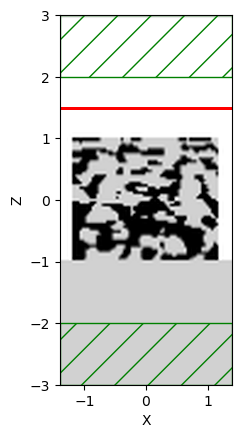

In [3]:
###############################################################################################################################

# ## 3. Design plot

opt.plot2D(False, output_plane = mp.Volume(size = (np.inf, 0, np.inf), center = (0,0,0)))
plt.savefig(design_dir+"Lastdesignxz.png")


     block, center = (0,0,0)
          size (2.4,2.4,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-2)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1,2.1,2.1)
     block, center = (0.7,0.7,-2)
          size (1,1,2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.8,11.8,11.8)
     block, center = (-0.7,-0.7,-2)
          size (1,1,2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.8,11.8,11.8)
     block, center = (0.7,-0.7,-2)
          size (1,1,2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.8,11.8,11.8)
     block, center = (-0.7,0.7,-2)
          size (1,1,2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.8,11.8,11.8)


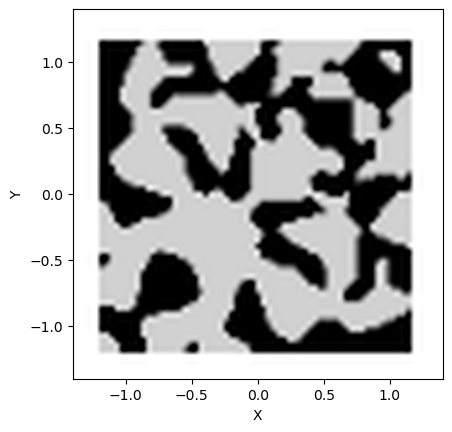

In [4]:
opt.plot2D(False, output_plane = mp.Volume(size = (np.inf, np.inf, 0), center = (0,0,1)))
plt.savefig(design_dir+"Lastdesignxy.png")

     block, center = (0,0,0)
          size (2.4,2.4,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-2)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1,2.1,2.1)
     block, center = (0.7,0.7,-2)
          size (1,1,2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.8,11.8,11.8)
     block, center = (-0.7,-0.7,-2)
          size (1,1,2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.8,11.8,11.8)
     block, center = (0.7,-0.7,-2)
          size (1,1,2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.8,11.8,11.8)
     block, center = (-0.7,0.7,-2)
          size (1,1,2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.8,11.8,11.8)


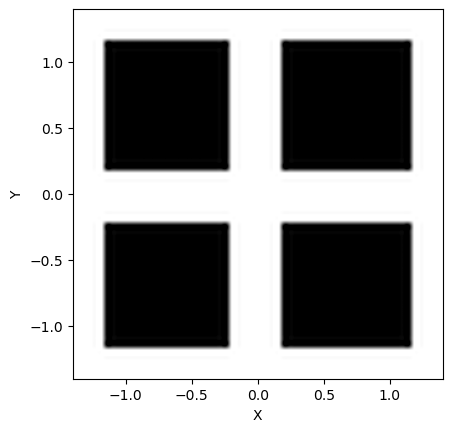

In [5]:
opt.plot2D(False, output_plane = mp.Volume(size = (np.inf, np.inf, 0), center = (0,0,-1.5)))
plt.savefig(design_dir+"LastdesignPD.png")

In [6]:
###############################################################################################################################
# ## 4. DFT fields

# blue pixel

opt.sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
    k_point = mp.Vector3(0,0,0)
)

src = mp.GaussianSource(frequency=frequencies[5], fwidth=fwidth_blue, is_integrated=True)
source = [mp.Source(src, component=mp.Ex, size=source_size, center=source_center),mp.Source(src, component=mp.Ey, size=source_size, center=source_center)]
opt.sim.change_sources(source)

plt.figure()

tran_Ex = opt.sim.add_dft_fields([mp.Ex], frequencies[5], 0 , 1, center = (0,0,-Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(design_region_width_x, design_region_width_y, 0), yee_grid=True)
tran_Ey = opt.sim.add_dft_fields([mp.Ey], frequencies[5], 0 , 1, center = (0,0,-Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(design_region_width_x, design_region_width_y, 0), yee_grid=True)
tran_Ez = opt.sim.add_dft_fields([mp.Ez], frequencies[5], 0 , 1, center = (0,0,-Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(design_region_width_x, design_region_width_y, 0), yee_grid=True)

tran_Hx = opt.sim.add_dft_fields([mp.Hx], frequencies[5], 0 , 1, center = (0,0,-Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(design_region_width_x, design_region_width_y, 0), yee_grid=True)
tran_Hy = opt.sim.add_dft_fields([mp.Hy], frequencies[5], 0 , 1, center = (0,0,-Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(design_region_width_x, design_region_width_y, 0), yee_grid=True)
tran_Hz = opt.sim.add_dft_fields([mp.Hz], frequencies[5], 0 , 1, center = (0,0,-Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(design_region_width_x, design_region_width_y, 0), yee_grid=True)

Ex_Namei="Ex_b_field"
Ey_Namei="Ey_b_field"
Ez_Namei="Ez_b_field"

Hx_Namei="Hx_b_field"
Hy_Namei="Hy_b_field"
Hz_Namei="Hz_b_field"

pt = mp.Vector3(0, 0, -Sz/2 + PDsize  - 0.5/resolution) #pt는 transmitted flux region과 동일

opt.sim.run(until_after_sources=mp.stop_when_fields_decayed(10,mp.Ex,pt,1e-3))

opt.sim.output_dft(tran_Ex,design_dir+Ex_Namei)
opt.sim.output_dft(tran_Ey,design_dir+Ey_Namei)
opt.sim.output_dft(tran_Ez,design_dir+Ez_Namei)

opt.sim.output_dft(tran_Hx,design_dir+Hx_Namei)
opt.sim.output_dft(tran_Hy,design_dir+Hy_Namei)
opt.sim.output_dft(tran_Hz,design_dir+Hz_Namei)

# blue_Ex = np.abs(opt.sim.get_dft_array(blue_x, mp.Ex, 0))**2
# blue_Ex = (blue_Ex / blue_Ex.max(axis=0).max(axis=0))

# blue_Ey = np.abs(opt.sim.get_dft_array(blue_y, mp.Ey, 0))**2
# blue_Ey = (blue_Ey / blue_Ey.max(axis=0).max(axis=0))

# plt.subplot(1,2,1)
# plt.title(' $\lambda$ = '+str(wavelengths[5]*1000/um_scale)+' nm')
# plt.imshow(npa.rot90(blue_Ex.reshape(design_region_width_x* resolution+1+1, design_region_width_y* resolution+1)),cmap="Blues")
# plt.colorbar()

# plt.subplot(1,2,2)
# plt.title('wavelength = '+str(wavelengths[5]/um_scale))
# plt.imshow(npa.rot90(blue_Ey.reshape(design_region_width_x* resolution+1, design_region_width_y* resolution+1+1)),cmap="Blues")
# plt.colorbar()
# plt.savefig(design_dir+"Blueintensity.png")

-----------
Initializing structure...
time for choose_chunkdivision = 4.19617e-05 s
Working in 3D dimensions.
Computational cell is 2.8 x 2.8 x 6 with resolution 25
     block, center = (0,0,0)
          size (2.4,2.4,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-2)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1,2.1,2.1)
     block, center = (0.7,0.7,-2)
          size (1,1,2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.8,11.8,11.8)
     block, center = (-0.7,-0.7,-2)
          size (1,1,2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.8,11.8,11.8)
     block, center = (0.7,-0.7,-2)
          size (1,1,2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.8,11.8,11.8)
     block, center = (-0.7,0.7,-2)
          size (1,1,2)
          axes (1,0,0), 

<Figure size 640x480 with 0 Axes>

In [7]:
# green pixel

opt.sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
    k_point = mp.Vector3(0,0,0)
)

src = mp.GaussianSource(frequency=frequencies[15], fwidth=fwidth_green, is_integrated=True)
source = [mp.Source(src, component=mp.Ex, size=source_size, center=source_center),mp.Source(src, component=mp.Ey, size=source_size, center=source_center)]
opt.sim.change_sources(source)

plt.figure()


tran_Ex = opt.sim.add_dft_fields([mp.Ex], frequencies[15], 0 , 1, center = (0,0,-Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(design_region_width_x, design_region_width_y, 0), yee_grid=True)
tran_Ey = opt.sim.add_dft_fields([mp.Ey], frequencies[15], 0 , 1, center = (0,0,-Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(design_region_width_x, design_region_width_y, 0), yee_grid=True)
tran_Ez = opt.sim.add_dft_fields([mp.Ez], frequencies[15], 0 , 1, center = (0,0,-Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(design_region_width_x, design_region_width_y, 0), yee_grid=True)

tran_Hx = opt.sim.add_dft_fields([mp.Hx], frequencies[15], 0 , 1, center = (0,0,-Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(design_region_width_x, design_region_width_y, 0), yee_grid=True)
tran_Hy = opt.sim.add_dft_fields([mp.Hy], frequencies[15], 0 , 1, center = (0,0,-Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(design_region_width_x, design_region_width_y, 0), yee_grid=True)
tran_Hz = opt.sim.add_dft_fields([mp.Hz], frequencies[15], 0 , 1, center = (0,0,-Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(design_region_width_x, design_region_width_y, 0), yee_grid=True)


opt.sim.run(until_after_sources=mp.stop_when_fields_decayed(10,mp.Ex,pt,1e-3))

Ex_Namei="Ex_g_field"
Ey_Namei="Ey_g_field"
Ez_Namei="Ez_g_field"

Hx_Namei="Hx_g_field"
Hy_Namei="Hy_g_field"
Hz_Namei="Hz_g_field"

opt.sim.output_dft(tran_Ex,design_dir+Ex_Namei)
opt.sim.output_dft(tran_Ey,design_dir+Ey_Namei)
opt.sim.output_dft(tran_Ez,design_dir+Ez_Namei)

opt.sim.output_dft(tran_Hx,design_dir+Hx_Namei)
opt.sim.output_dft(tran_Hy,design_dir+Hy_Namei)
opt.sim.output_dft(tran_Hz,design_dir+Hz_Namei)





-----------
Initializing structure...
time for choose_chunkdivision = 3.79086e-05 s
Working in 3D dimensions.
Computational cell is 2.8 x 2.8 x 6 with resolution 25
     block, center = (0,0,0)
          size (2.4,2.4,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-2)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1,2.1,2.1)
     block, center = (0.7,0.7,-2)
          size (1,1,2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.8,11.8,11.8)
     block, center = (-0.7,-0.7,-2)
          size (1,1,2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.8,11.8,11.8)
     block, center = (0.7,-0.7,-2)
          size (1,1,2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.8,11.8,11.8)
     block, center = (-0.7,0.7,-2)
          size (1,1,2)
          axes (1,0,0), 

<Figure size 640x480 with 0 Axes>

In [8]:
# red pixel

opt.sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
    k_point = mp.Vector3(0,0,0)
)

src = mp.GaussianSource(frequency=frequencies[25], fwidth=fwidth_green, is_integrated=True)
source = [mp.Source(src, component=mp.Ex, size=source_size, center=source_center),mp.Source(src, component=mp.Ey, size=source_size, center=source_center)]
opt.sim.change_sources(source)

plt.figure()

red_y = opt.sim.add_dft_fields([mp.Ey], frequencies[25], 0 , 1, center = (0,0,-Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(design_region_width_x, design_region_width_y, 0), yee_grid=True)
red_x = opt.sim.add_dft_fields([mp.Ex], frequencies[25], 0 , 1, center = (0,0,-Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(design_region_width_x, design_region_width_y, 0), yee_grid=True)


tran_Ex = opt.sim.add_dft_fields([mp.Ex], frequencies[25], 0 , 1, center = (0,0,-Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(design_region_width_x, design_region_width_y, 0), yee_grid=True)
tran_Ey = opt.sim.add_dft_fields([mp.Ey], frequencies[25], 0 , 1, center = (0,0,-Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(design_region_width_x, design_region_width_y, 0), yee_grid=True)
tran_Ez = opt.sim.add_dft_fields([mp.Ez], frequencies[25], 0 , 1, center = (0,0,-Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(design_region_width_x, design_region_width_y, 0), yee_grid=True)

tran_Hx = opt.sim.add_dft_fields([mp.Hx], frequencies[25], 0 , 1, center = (0,0,-Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(design_region_width_x, design_region_width_y, 0), yee_grid=True)
tran_Hy = opt.sim.add_dft_fields([mp.Hy], frequencies[25], 0 , 1, center = (0,0,-Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(design_region_width_x, design_region_width_y, 0), yee_grid=True)
tran_Hz = opt.sim.add_dft_fields([mp.Hz], frequencies[25], 0 , 1, center = (0,0,-Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(design_region_width_x, design_region_width_y, 0), yee_grid=True)

opt.sim.run(until_after_sources=mp.stop_when_fields_decayed(10,mp.Ex,pt,1e-3))

Ex_Namei="Ex_r_field"
Ey_Namei="Ey_r_field"
Ez_Namei="Ez_r_field"

Hx_Namei="Hx_r_field"
Hy_Namei="Hy_r_field"
Hz_Namei="Hz_r_field"

opt.sim.output_dft(tran_Ex,design_dir+Ex_Namei)
opt.sim.output_dft(tran_Ey,design_dir+Ey_Namei)
opt.sim.output_dft(tran_Ez,design_dir+Ez_Namei)

opt.sim.output_dft(tran_Hx,design_dir+Hx_Namei)
opt.sim.output_dft(tran_Hy,design_dir+Hy_Namei)
opt.sim.output_dft(tran_Hz,design_dir+Hz_Namei)


-----------
Initializing structure...
time for choose_chunkdivision = 3.88622e-05 s
Working in 3D dimensions.
Computational cell is 2.8 x 2.8 x 6 with resolution 25
     block, center = (0,0,0)
          size (2.4,2.4,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-2)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1,2.1,2.1)
     block, center = (0.7,0.7,-2)
          size (1,1,2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.8,11.8,11.8)
     block, center = (-0.7,-0.7,-2)
          size (1,1,2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.8,11.8,11.8)
     block, center = (0.7,-0.7,-2)
          size (1,1,2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.8,11.8,11.8)
     block, center = (-0.7,0.7,-2)
          size (1,1,2)
          axes (1,0,0), 

<Figure size 640x480 with 0 Axes>

In [9]:
##############################################################################################################################
# ## 5. Optical Efficiency
opt.sim.reset_meep()

# simulation 1 : geometry가 없는 구조
geometry_1 = [
    mp.Block(
        center=mp.Vector3(0, 0, 0), size=mp.Vector3(Sx, Sy, 0), material=Air
    )
]

opt.sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry_1,
    sources=source,
    default_material=Air,
    resolution=resolution,
    k_point = mp.Vector3(0,0,0)
)

fcen = (1/(0.40 * um_scale) + 1/(0.70 * um_scale))/2
df = 1 /(0.40 * um_scale) - 1/(0.70 * um_scale)
nfreq = 300

src = mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True)
source = [mp.Source(src, component=mp.Ey, size=source_size, center=source_center),mp.Source(src, component=mp.Ex, size=source_size, center=source_center)]
opt.sim.change_sources(source)

     block, center = (0,0,0)
          size (2.8,2.8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


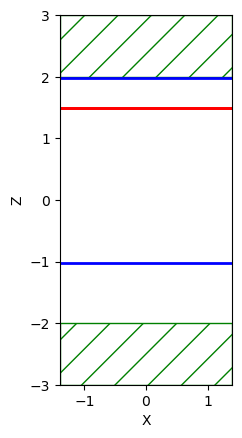

In [10]:
# reflection moniter 설정

refl_fr = mp.FluxRegion(
    center=mp.Vector3(0, 0, Sz/2 - Lpml - 0.5/resolution), size=mp.Vector3(Sx, Sy, 0)
) 
refl = opt.sim.add_flux(fcen, df, nfreq, refl_fr)

# transmission moiniter 설정

tran_t = mp.FluxRegion(
    center=mp.Vector3(0, 0, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(Sx, Sy, 0)
)
tran_total = opt.sim.add_flux(fcen, df, nfreq, tran_t)


# pt는 transmitted flux region과 동일

pt = mp.Vector3(0, 0, -Sz/2 + PDsize - 0.5/resolution)

opt.plot2D(False, output_plane = mp.Volume(size = (np.inf, 0, np.inf), center = (0,0,0)))


In [11]:
#source가 끝난 후에 50 동안 계속 실행하며 component는 Ey, pt 설계의 끝에서 |Ey|^2의 값이 최대 값으로부터 1/1000 만큼 감쇠할때까지
#추가적인 50 단위의 시간 실행 -> Fourier-transform 수렴예상

opt.sim.run(until_after_sources=mp.stop_when_fields_decayed(10,mp.Ex,pt,1e-4))

#데이터 저장

straight_refl_data = opt.sim.get_flux_data(refl)
total_flux = mp.get_fluxes(tran_total)
flux_freqs = mp.get_flux_freqs(tran_total)

-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 2.8 x 2.8 x 6 with resolution 25
     block, center = (0,0,0)
          size (2.8,2.8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.940818 s
-----------
on time step 303 (time=6.06), 0.0132197 s/step
field decay(t = 10.02): 0.07632952008595714 / 0.07632952008595714 = 1.0
on time step 634 (time=12.68), 0.0120975 s/step
on time step 969 (time=19.38), 0.0119664 s/step
field decay(t = 20.04): 0.24575982250892364 / 0.24575982250892364 = 1.0
on time step 1307 (time=26.14), 0.0118595 s/step
field decay(t = 30.060000000000002): 6.895178303735426e-10 / 0.24575982250892364 = 2.8056572605496e-09
run 0 finished at t = 30.060000000000002 (1503 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 3.57628e-05 s
Working in 3D dimensions.
Computational cell is 2.8 x 2.8 x 6 with resolution 25
     block, center = (0,0,0)
          size (2.4,2.4,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-2)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1,2.1,2.1)
     block, center = (0.7,0.7,-2)
          size (1,1,2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.8,11.8,11.8)
     block, center = (-0.7,-0.7,-2)
          size (1,1,2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.8,11.8,11.8)
     block, center = (0.7,-0.7,-2)
          size (1,1,2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.8,11.8,11.8)
     block, center = (-0.7,0.7,-2)
          size (1,1,2)
          axes (1,0,0), 

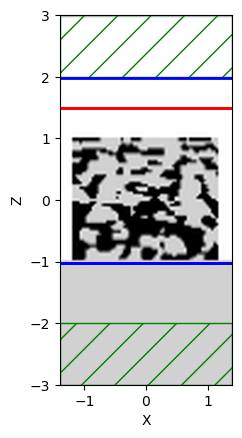

In [12]:
opt.sim.reset_meep()

# simulation 2 : geometry가 있는 구조

opt.sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
    k_point = mp.Vector3(0,0,0)
)


# 반사된 flux 구하기

refl = opt.sim.add_flux(fcen, df, nfreq, refl_fr)

# 투과된 flux 구하기

tran = opt.sim.add_flux(fcen, df, nfreq, tran_t)

# 픽셀에 들어온 flux 구하기

tran_p = mp.FluxRegion(
    center=mp.Vector3(0, 0, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(design_region_width_x, design_region_width_y, 0)
)

tran_pixel = opt.sim.add_flux(fcen, df, nfreq, tran_p)

#반사된 필드와 입사되는 필드를 구분하기 위해서 The Fourier-transformed incident fields을
#the Fourier transforms of the scattered fields 에서 빼줍니다.

opt.sim.load_minus_flux_data(refl, straight_refl_data)

#각각 픽셀의 flux 구하기

tran_g = mp.FluxRegion(
    center=mp.Vector3(-design_region_width_x/4, design_region_width_y/4, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_r = mp.FluxRegion(
    center=mp.Vector3(-design_region_width_x/4, -design_region_width_y/4, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_g0 = mp.FluxRegion(
    center=mp.Vector3(design_region_width_x/4, -design_region_width_y/4, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_b = mp.FluxRegion(
    center=mp.Vector3(design_region_width_x/4, design_region_width_y/4, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)

tran_red = opt.sim.add_flux(fcen, df, nfreq, tran_r)
tran_green = opt.sim.add_flux(fcen, df, nfreq, tran_g)
tran_blue = opt.sim.add_flux(fcen, df, nfreq, tran_b)
tran_green0 = opt.sim.add_flux(fcen, df, nfreq, tran_g0)

opt.plot2D(False, output_plane = mp.Volume(size = (np.inf, 0, np.inf), center = (0,0,0)))

In [13]:
opt.sim.run(until_after_sources=mp.stop_when_fields_decayed(10,mp.Ex,pt,1e-4))

# 데이터 저장

refl_flux = mp.get_fluxes(refl)
tran_flux = mp.get_fluxes(tran)
tran_flux_p = mp.get_fluxes(tran_pixel)

red_flux = mp.get_fluxes(tran_red)
green_flux = mp.get_fluxes(tran_green)
blue_flux = mp.get_fluxes(tran_blue)
green_flux0 = mp.get_fluxes(tran_green0)

on time step 232 (time=4.64), 0.0172897 s/step
on time step 490 (time=9.8), 0.0155403 s/step
field decay(t = 10.02): 0.00025344360942660044 / 0.00025344360942660044 = 1.0
on time step 752 (time=15.04), 0.0152897 s/step
field decay(t = 20.04): 0.030390012091497595 / 0.030390012091497595 = 1.0
on time step 1010 (time=20.2), 0.0155101 s/step
on time step 1270 (time=25.4), 0.0153974 s/step
field decay(t = 30.060000000000002): 0.02993665016240442 / 0.030390012091497595 = 0.9850818773046814
on time step 1530 (time=30.6), 0.0154275 s/step
on time step 1789 (time=35.78), 0.0154878 s/step
field decay(t = 40.06): 0.023243316627139278 / 0.030390012091497595 = 0.7648340697318184
on time step 2044 (time=40.88), 0.0157075 s/step
on time step 2304 (time=46.08), 0.0154953 s/step
field decay(t = 50.08): 0.0036532196059349186 / 0.030390012091497595 = 0.12021119290561266
on time step 2565 (time=51.3), 0.0153663 s/step
on time step 2824 (time=56.48), 0.0154543 s/step
field decay(t = 60.1): 0.0035072777587

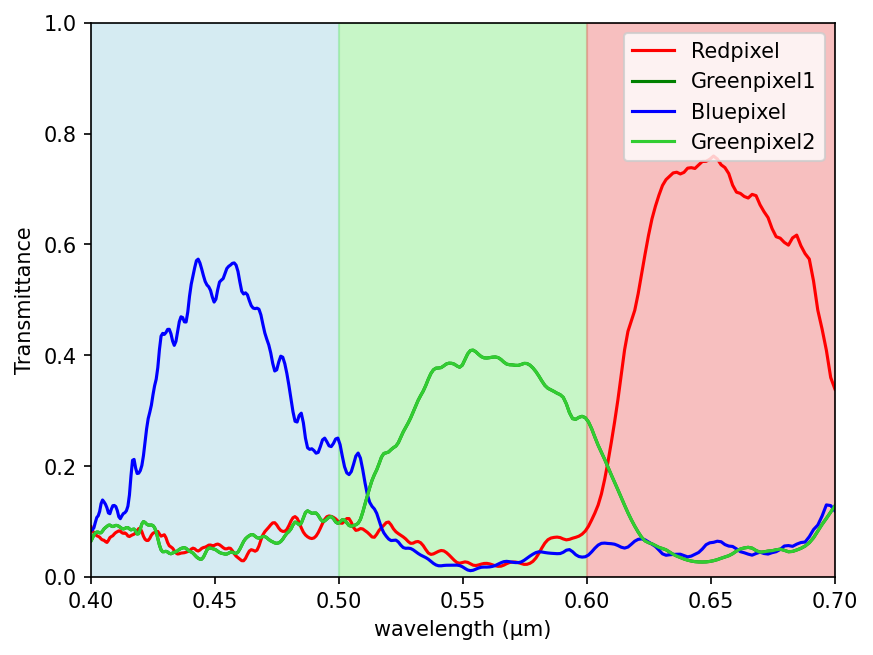

In [14]:
# totalflux 대비 효율

wl = []
Tr = []
Tg = []
Tb = []
Tg0 = []
for i in range(nfreq):
    wl = np.append(wl, 1 / (flux_freqs[i] * um_scale))
    Tr = np.append(Tr, red_flux[i] / total_flux[i])
    Tg = np.append(Tg, green_flux[i] / total_flux[i])
    Tb = np.append(Tb, blue_flux[i] / total_flux[i])
    Tg0 = np.append(Tg0, green_flux0[i] / total_flux[i])

if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, Tr, "r", label="Redpixel")
    plt.plot(wl, Tg, "g", label="Greenpixel1")
    plt.plot(wl, Tb, "b", label="Bluepixel")
    plt.plot(wl, Tg0, color='limegreen', label="Greenpixel2")
    
    plt.axis([0.40, 0.70, 0, 1])
    plt.xlabel("wavelength (μm)")
    plt.ylabel("Transmittance")
    plt.fill([0.40, 0.40, 0.50, 0.50], [0.0, 1.0, 1.0, 0.0], color='lightblue', alpha=0.5)
    plt.fill([0.50, 0.50, 0.60, 0.60], [0.0, 1.0, 1.0, 0.0], color='lightgreen', alpha=0.5)
    plt.fill([0.60, 0.60, 0.70, 0.70], [0.0, 1.0, 1.0, 0.0], color='lightcoral', alpha=0.5)
    plt.legend(loc="upper right")
    plt.savefig(design_dir+"TransmissionEfficiency.png")

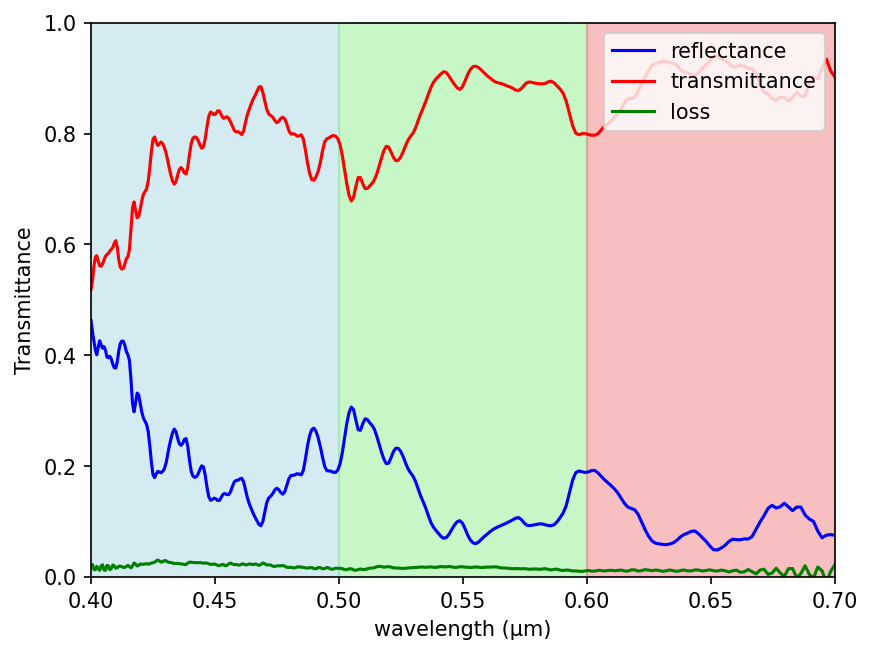

In [15]:
# 투과율과 반사율

Rs = []
Ts = []
for i in range(nfreq):
    Rs = np.append(Rs, -refl_flux[i] / total_flux[i])
    Ts = np.append(Ts, tran_flux[i] / total_flux[i])

if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, Rs, "b", label="reflectance")
    plt.plot(wl, Ts, "r", label="transmittance")
    plt.plot(wl, 1 - Rs - Ts, "g", label="loss")
    plt.axis([0.40, 0.70, 0, 1])
    plt.xlabel("wavelength (μm)")
    plt.ylabel("Transmittance")
    plt.fill([0.40, 0.40, 0.50, 0.50], [0.0, 1.0, 1.0, 0.0], color='lightblue', alpha=0.5)
    plt.fill([0.50, 0.50, 0.60, 0.60], [0.0, 1.0, 1.0, 0.0], color='lightgreen', alpha=0.5)
    plt.fill([0.60, 0.60, 0.70, 0.70], [0.0, 1.0, 1.0, 0.0], color='lightcoral', alpha=0.5)
    plt.legend(loc="upper right")
    #plt.show()
    plt.savefig(design_dir+"T_R.png")

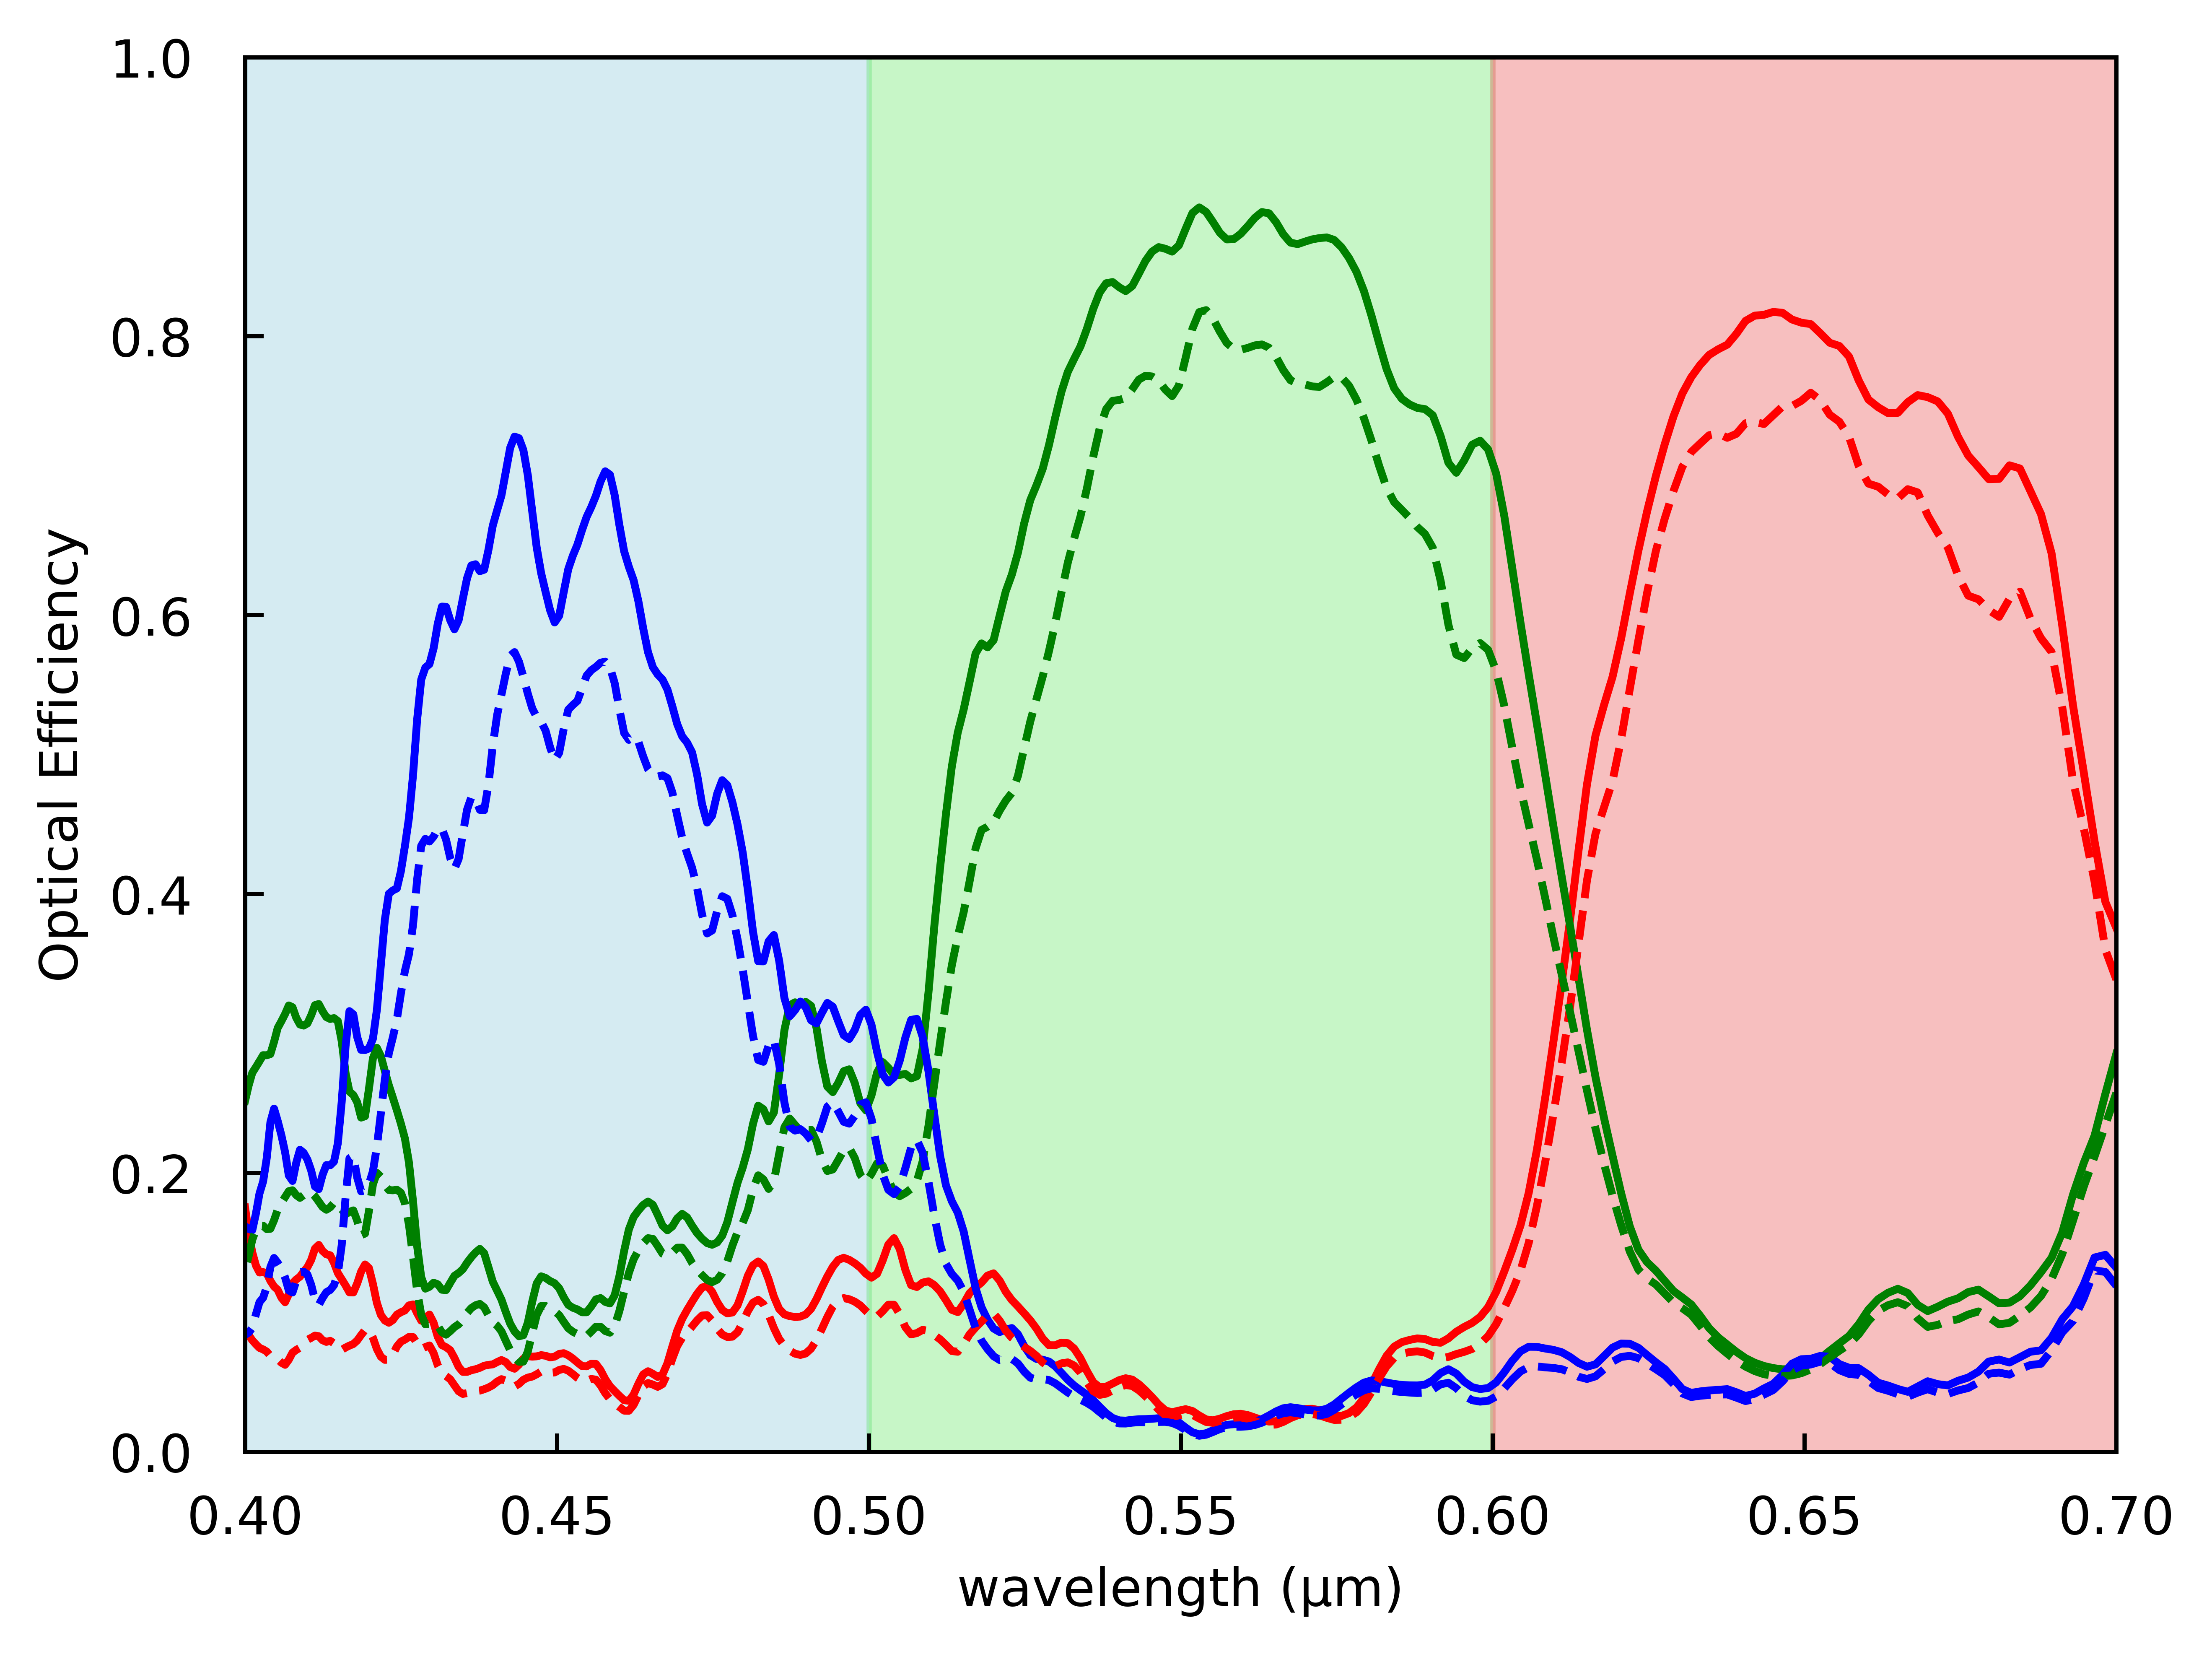

In [16]:
# 입사 flux 대비 효율

wl = []
Tr = []
Tg = []
Tb = []
Tg0 = []

Trt = []
Tgt = []
Tbt = []
Tg0t = []
for i in range(nfreq):
    wl = np.append(wl, 1 / (flux_freqs[i] * um_scale))
    Tr = np.append(Tr, red_flux[i] / tran_flux_p[i])
    Tg = np.append(Tg, green_flux[i] /tran_flux_p[i])
    Tb = np.append(Tb, blue_flux[i] / tran_flux_p[i])
    Tg0 = np.append(Tg0, green_flux0[i] / tran_flux_p[i])

    Trt = np.append(Trt, red_flux[i] / total_flux[i])
    Tgt = np.append(Tgt, green_flux[i] / total_flux[i])
    Tbt = np.append(Tbt, blue_flux[i] / total_flux[i])
    Tg0t = np.append(Tg0t, green_flux0[i] / total_flux[i])
if mp.am_master():
    plt.figure(dpi=900)
    plt.plot(wl, Tr, "r",)
    plt.plot(wl, Tg+Tg0, "g",)
    plt.plot(wl, Tb, "b",)
    plt.plot(wl, Trt, "r--",)
    plt.plot(wl, Tgt+Tg0t, "g--",)
    plt.plot(wl, Tbt, "b--",)
    #plt.plot(wl, Tg0, color='limegreen', label="Greenpixel2")
    
    plt.axis([0.40, 0.70, 0.0, 1.0])
    plt.xlabel("wavelength (μm)")
    plt.ylabel("Optical Efficiency")
    plt.fill([0.40, 0.40, 0.50, 0.50], [-0.03, 1.03, 1.03, -0.03], color='lightblue', alpha=0.5)
    plt.fill([0.50, 0.50, 0.60, 0.60], [-0.03, 1.03, 1.03, -0.03], color='lightgreen', alpha=0.5)
    plt.fill([0.60, 0.60, 0.70, 0.70], [-0.03, 1.03, 1.03, -0.03], color='lightcoral', alpha=0.5)
    plt.tick_params(axis='x', direction='in', pad = 8)
    plt.tick_params(axis='y', direction='in', pad = 10)
    #plt.show()
    plt.savefig(design_dir+"Optical Efficiency.png")

In [17]:
print(np.mean(Tr[0:66]))
print(np.mean(Tg[66:160]))
print(np.mean(Tb[160:300]))
print(max(Tr[0:66]))
print(max(Tg[66:160]))
print(max(Tb[160:300]))
print(max((Tr - Tg)[0:66]))
print(max((Tg - Tr)[66:160]))
print(max((Tb - Tr)[160:300]))
print(np.mean(Tr[66:300]))
print((sum(Tg[0:66]) + sum(Tg[160:300]))/206)
print(np.mean(Tb[0:160]))

0.6330316795934273
0.35355212766252675
0.4485568250120664
0.8174212909302584
0.4461760388546577
0.7280142838211885
0.7873751441852316
0.42232228207021216
0.6683656478107075
0.08655040645151765
0.09839109033531943
0.07544408287197961
